In [2]:
import sys
import numpy
import random
import statistics
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [3]:
# Create a spark session/application
spark = SparkSession.builder.appName('Term_Statistics').getOrCreate()

In [4]:
# Import train_gps_points.csv as dataframe using the defined schema
schema = StructType(
    [
        StructField("Datetime", StringType(), False),
        StructField("Longitude_X", FloatType(), False),
        StructField("Latitude_Y", FloatType(), False),
        StructField("Zone_ID", ByteType(), False)
    ]
)
gps_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .schema(schema)\
        .load("data/train_gps_points.csv")

gps_df = gps_df.withColumn("Date", F.substring(F.col("Datetime"), 0, 10))
gps_df = gps_df.withColumn("Datetime", F.to_timestamp(F.substring(F.col("Datetime"), 0, 19)))

In [5]:
# Import train_hire_stats.csv as dataframe using the defined schema
schema = StructType(
    [
        StructField("Zone_ID", ByteType(), False),
        StructField("Date", TimestampType(), False),
        StructField("Hour_slot", ByteType(), False),
        StructField("Hire_count", ShortType(), False)
    ]
)
train_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .schema(schema)\
        .load("data/train_hire_stats.csv")

train_df = train_df.withColumn('Day_of_the_week', 
                               (F.date_format(train_df["Date"], "u").cast(IntegerType())))

train_df = train_df.withColumn('Month', 
                               (F.date_format(train_df["Date"], "M").cast(IntegerType())))

In [6]:
# Import test_hire_stats.csv as dataframe using the defined schema
schema = StructType(
    [
        StructField("Test_ID", ShortType(), False),
        StructField("Zone_ID", ByteType(), False),
        StructField("Date", TimestampType(), False),
        StructField("Hour_slot", ByteType(), False),
        StructField("Hire_count", ByteType(), False)
    ]
)
test_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .schema(schema)\
        .load("data/test_hire_stats.csv")

In [7]:
# Import zones.csv as dataframe using the defined schema
schema = StructType(
    [
        StructField("Zone_ID", ByteType(), False),
        StructField("left", FloatType(), False),
        StructField("top", FloatType(), False),
        StructField("right", FloatType(), False),
        StructField("bottom", FloatType(), False)
    ]
)
zones_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .schema(schema)\
        .load("data/zones.csv")

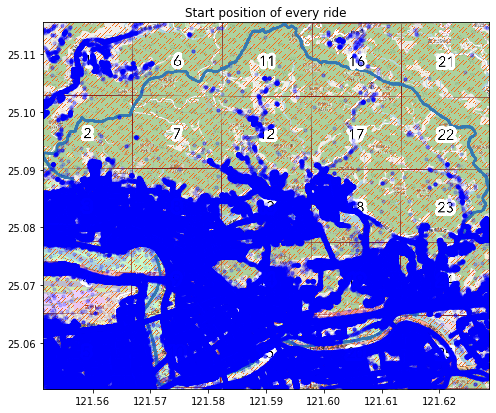

In [7]:
left_edge = zones_df.select(F.min(F.col("left"))).collect()[0][0]
top_edge = zones_df.select(F.max(F.col("top"))).collect()[0][0]
right_edge = zones_df.select(F.max(F.col("right"))).collect()[0][0]
bottom_edge = zones_df.select(F.min(F.col("bottom"))).collect()[0][0]

BBox = (left_edge, right_edge, bottom_edge, top_edge)

x = [float(row.Longitude_X) for row in gps_df.collect()]
y = [float(row.Latitude_Y) for row in gps_df.collect()]

mapimg = plt.imread('data/zones-borderless.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(x, y, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Start position of every ride')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapimg, zorder=0, extent = BBox, aspect= 'equal')

fig.savefig("output/ridesmapall.png", dpi=1000)

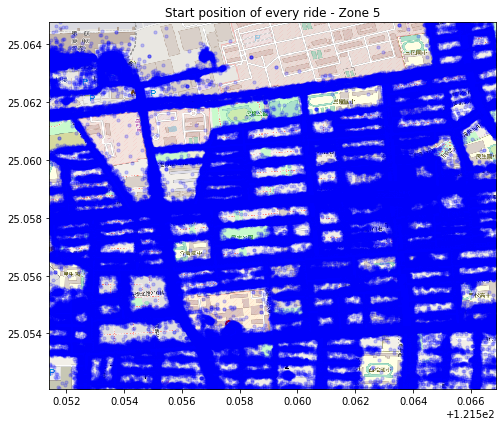

In [13]:
zone_id = 5

zone = gps_df.select("Longitude_X", "Latitude_Y").where(F.col("Zone_ID") == zone_id)
left_edge = zones_df.select("left").where(F.col("Zone_ID") == zone_id).collect()[0][0]
top_edge = zones_df.select("top").where(F.col("Zone_ID") == zone_id).collect()[0][0]
right_edge = zones_df.select("right").where(F.col("Zone_ID") == zone_id).collect()[0][0]
bottom_edge = zones_df.select("bottom").where(F.col("Zone_ID") == zone_id).collect()[0][0]

BBox = (left_edge, right_edge, bottom_edge, top_edge)

x = [float(row.Longitude_X) for row in zone.collect()]
y = [float(row.Latitude_Y) for row in zone.collect()]

mapimg = plt.imread(f'data/zone{zone_id}.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(x, y, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title(f'Start position of every ride - Zone {zone_id}')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(mapimg, zorder=0, extent = BBox, aspect= 'equal')

fig.savefig(f"output/ridesmapzones/zone{zone_id}.png", dpi=1000)

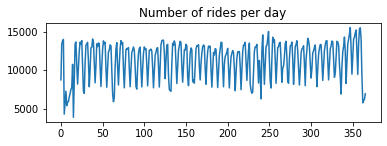

In [43]:
rides_perday = gps_df.groupBy("Date").count().orderBy("Date")
rides_perday = [row["count"] for row in rides_perday.collect()]

plt.figure()
plt.subplot('211')
plt.title('Number of rides per day')
plt.plot(rides_perday)
plt.savefig('output/ridesperday.png', dpi=1000)
plt.show()

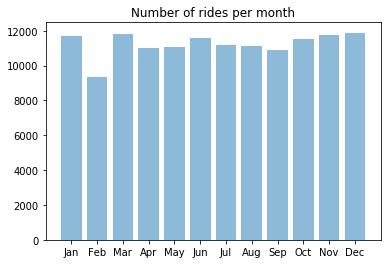

In [10]:
rides_monthyear = train_df.groupBy("Month").sum("Hire_count").orderBy(F.asc("Month"))
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

dates_permonth = train_df.groupBy("Month").agg(F.countDistinct('Date').alias('days')).orderBy(F.asc("Month"))
rides_monthyear = rides_monthyear.join(dates_permonth, "Month")
rides_monthyear = rides_monthyear.withColumn("count", F.col("sum(Hire_count)") / F.col("days")).orderBy(F.asc("Month"))
rides_monthyear = [row["count"] for row in rides_monthyear.collect()]
plt.bar(months, rides_monthyear, align='center', alpha=0.5)
plt.title('Number of rides per month')
plt.savefig('output/ridespermonth.png', dpi=1000)
plt.show()

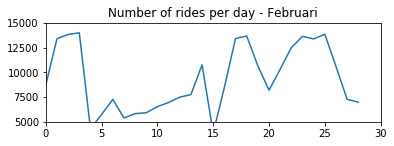

In [16]:
rides_perday = train_df.where("Month == 2").groupBy("Date").sum("Hire_count").orderBy("Date")
rides_perday = [row["sum(Hire_count)"] for row in rides_perday.collect()]

plt.figure()
plt.subplot('211')
plt.axis([0, 30, 5000, 15000])
plt.title('Number of rides per day - Februari')
plt.plot(rides_perday)
plt.savefig('output/ridesperdayfeb.png', dpi=1000)
plt.show()


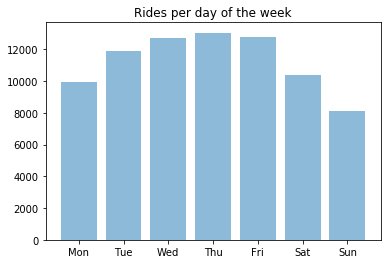

In [17]:
rides_weekday = train_df.groupBy("Day_of_the_week", "Date").sum("Hire_count")
rides_weekday = rides_weekday.groupBy("Day_of_the_week").mean("sum(Hire_count)").orderBy(F.asc("Day_of_the_week"))
rides_weekday = [row["avg(sum(Hire_count))"] for row in rides_weekday.collect()]  
weekdays = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")

plt.bar(weekdays, rides_weekday, align='center', alpha=0.5)
plt.title('Rides per day of the week')
plt.savefig('output/ridesperdayweek.png', dpi=1000)
plt.show()

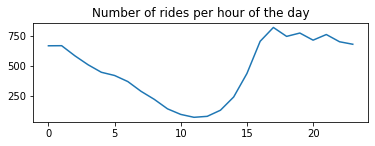

In [18]:
rides_hourday = train_df.groupBy("Hour_slot", "Date").sum("Hire_count")
rides_hourday = rides_hourday.groupBy("Hour_slot").mean("sum(Hire_count)").orderBy("Hour_slot")
rides_hourday = [row["avg(sum(Hire_count))"] for row in rides_hourday.collect()]

plt.figure()
plt.subplot('211')
plt.title('Number of rides per hour of the day')
plt.plot(rides_hourday)
plt.savefig('output/ridesperhourday.png', dpi=1000)
plt.show()

In [20]:
rides_perzone = gps_df.groupBy("Zone_ID").count().orderBy("Zone_ID")

orig_stdout = sys.stdout
f = open('output/ridesperzone.txt', 'w')
sys.stdout = f

rides_perzone.show(25)

sys.stdout = orig_stdout
f.close()

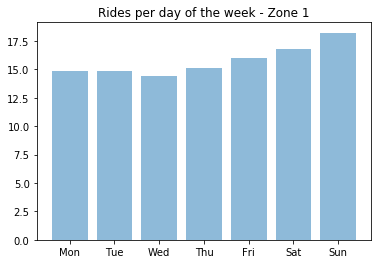

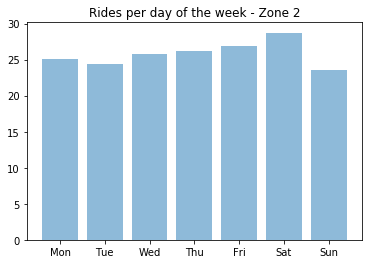

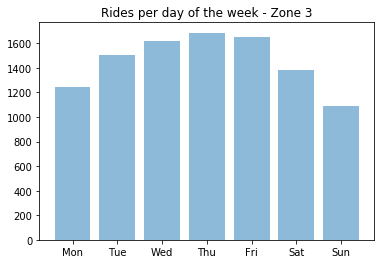

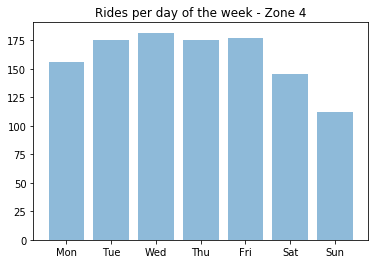

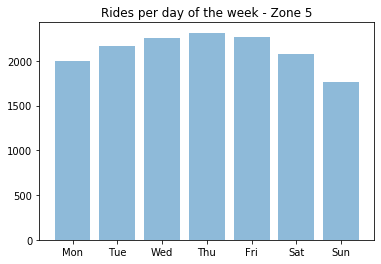

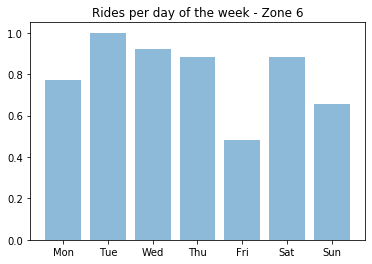

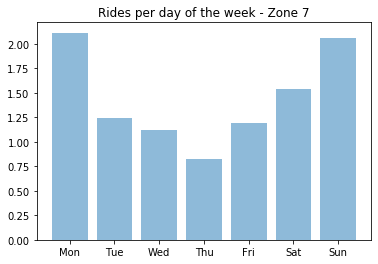

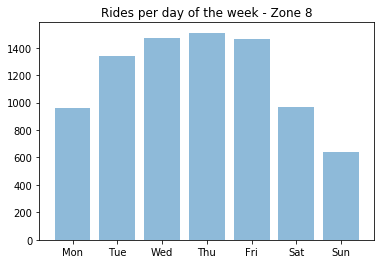

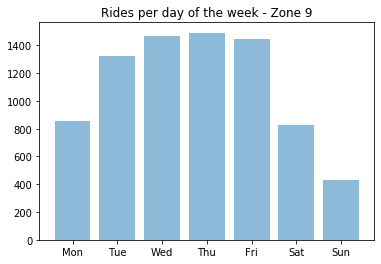

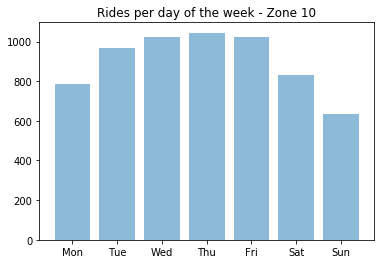

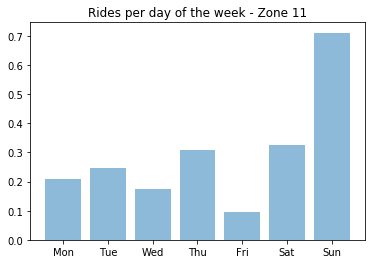

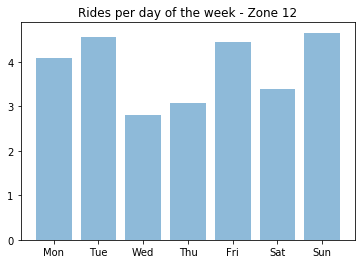

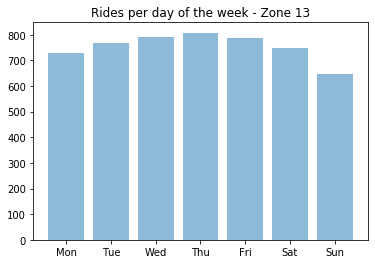

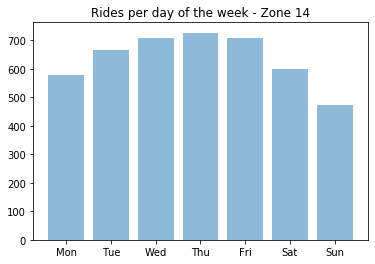

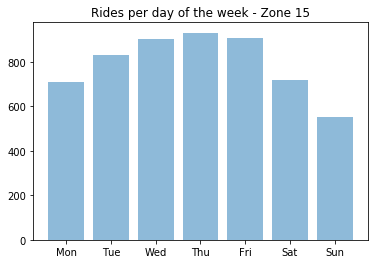

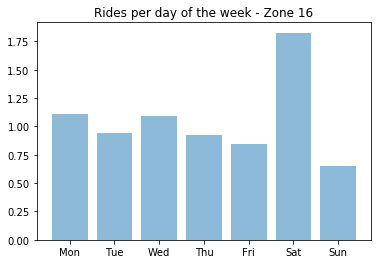

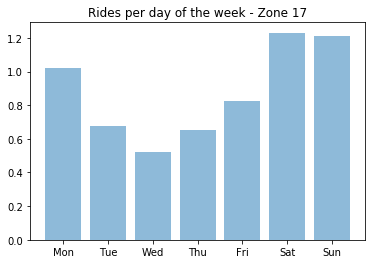

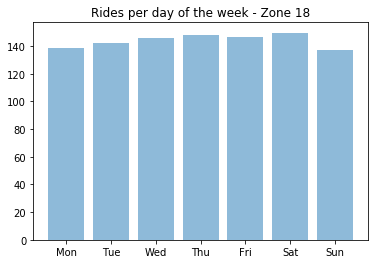

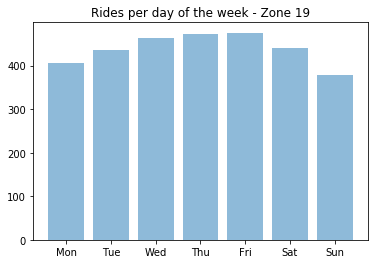

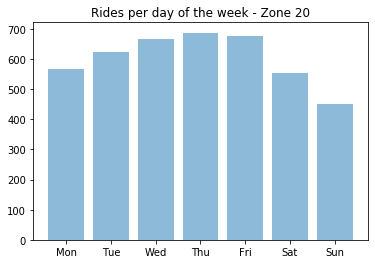

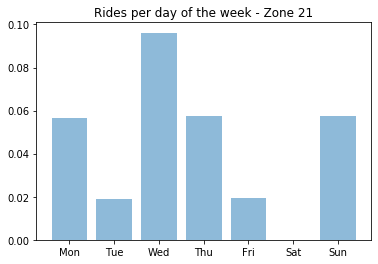

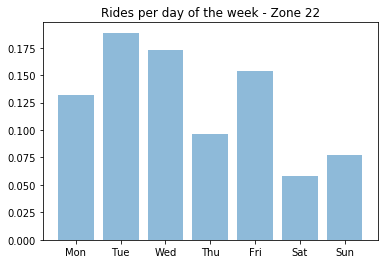

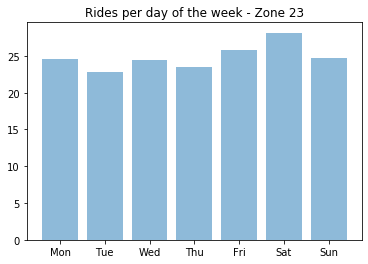

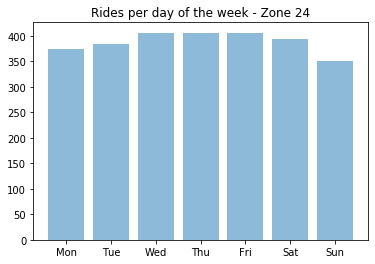

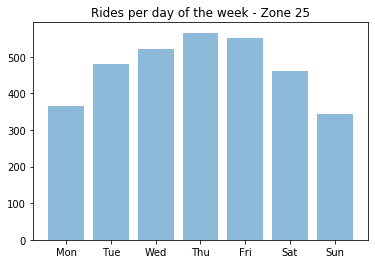

In [21]:
weekdays = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")

for i in range(1,26):
    zone_df = train_df.where(f"Zone_ID == {i}")
    rides_weekday_zone = zone_df.groupBy("Day_of_the_week", "Date").sum("Hire_count")
    rides_weekday_zone = rides_weekday_zone.groupBy("Day_of_the_week").mean("sum(Hire_count)").orderBy(F.asc("Day_of_the_week"))
    rides_weekday_zone = [row["avg(sum(Hire_count))"] for row in rides_weekday_zone.collect()]  

    plt.bar(weekdays, rides_weekday_zone, align='center', alpha=0.5)
    plt.title(f'Rides per day of the week - Zone {i}')
    plt.savefig(f'output/ridesperdayweekzones/zone{i}.png', dpi=1000)
    plt.show()

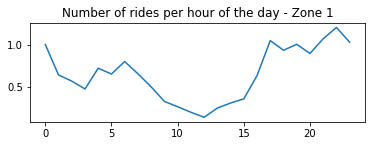

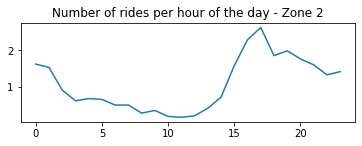

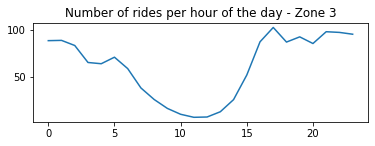

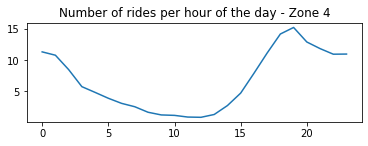

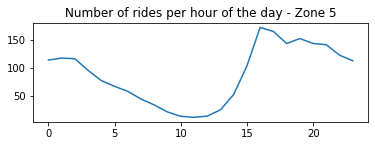

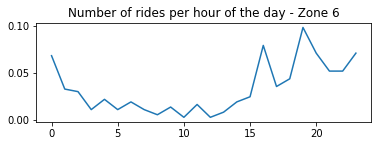

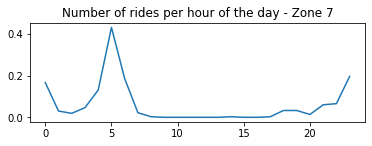

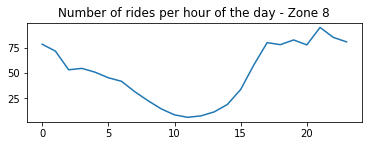

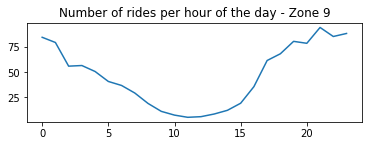

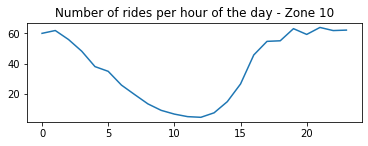

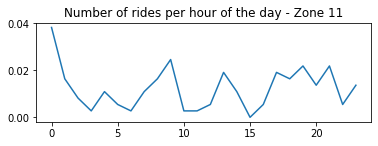

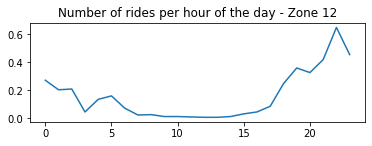

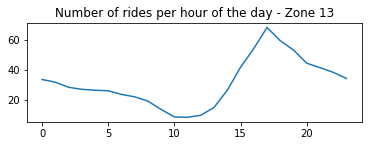

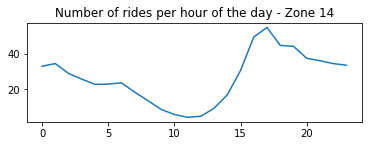

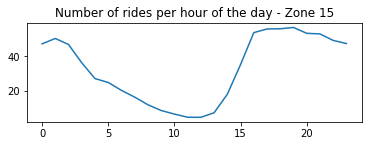

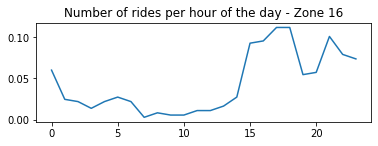

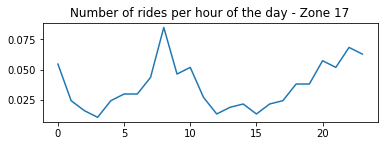

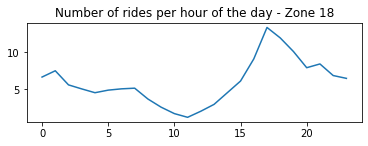

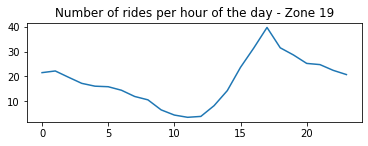

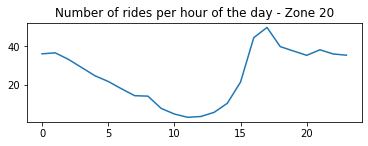

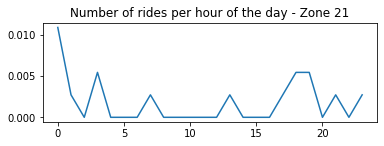

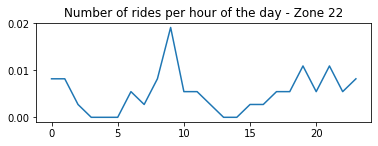

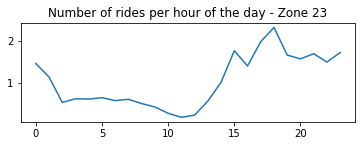

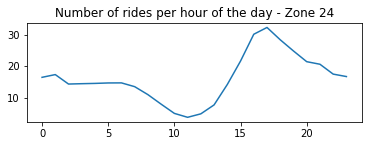

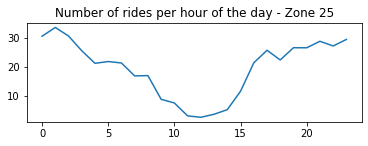

In [9]:
for i in range(1,26):
    zone_df = train_df.where(f"Zone_ID == {i}")
    
    rides_hourday_zone = zone_df.groupBy("Hour_slot", "Date").sum("Hire_count")
    rides_hourday_zone = rides_hourday_zone.groupBy("Hour_slot").mean("sum(Hire_count)").orderBy("Hour_slot")
    rides_hourday_zone = [row["avg(sum(Hire_count))"] for row in rides_hourday_zone.collect()]

    plt.figure()
    plt.subplot('211')
    plt.title(f'Number of rides per hour of the day - Zone {i}')
    plt.plot(rides_hourday_zone)
    plt.savefig(f'output/ridesperhourdayzones/zone{i}.png', dpi=1000)
    plt.show()

In [158]:
total_rides = sum(rides_perday)
avg_ridesperday = statistics.mean(rides_perday)
avg_ridesperhour = statistics.mean(rides_hourday)
avg_ridesperzone = statistics.mean(rides_perzone) / (366 * 24)
print(f'Total number of rides: {total_rides}')
print(f'Average number of rides per day: {avg_ridesperday}')
print(f'Average number of rides per hour: {avg_ridesperhour}')
print(f'Average number of rides per zone per hour: {avg_ridesperzone}')

Total number of rides: 4118812
Average number of rides per day: 11253.584699453551
Average number of rides per hour: 171617.16666666666
Average number of rides per zone per hour: 18.755974499089255
